# Model Selection - Classification

Testing out different classification models and selecting what seems to perform the best. (I honestly have no idea what I'm doing.)

## Setup

In [490]:
import csv
import json
import os
import time
from datetime import datetime

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pandas import DataFrame

# suppress future warnings for xgboost and unsupported kanji unicode in plots
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

import xgboost as xgb
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

In [491]:
SEED = 1337
data_dir = os.path.abspath('data')

# today = datetime.today().strftime('%Y%m%d')
today = datetime.strptime('2022-09-27', '%Y-%m-%d').strftime('%Y%m%d')

In [492]:
def print_model_results(y_test, y_pred):
    print('Log loss =', metrics.log_loss(y_test, y_pred)) # closer to zero, more accurate
    print(metrics.confusion_matrix(y_test, y_pred))
    # TODO: AUC
    print(metrics.classification_report(y_test, y_pred, digits=6))
    # precision: ratio of true positives to sum of true and false positives
    # recall:    ratio of true positives to sum of true positives and false negatives
    # f1 score:  weighted harmonic mean of precision and recall; closer to one, more accurate
    # support:   number of occurrences in dataset

def display_roc(y_test, y_proba):
    roc = metrics.roc_auc_score(y_test, y_proba) # closer to one, more accurate
    print('ROC AUC Score =', roc)

    # generally don't want ROC curve close to line; closer to axes, more accurate
    fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)
    roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color='g')

## Encoding / Feature Engineering

In [493]:
# binary encode a column of categorical data
def binary_encode(df: DataFrame, col: str) -> DataFrame:
    try:
        df[col] = df[col].apply(json.loads) # deserialize JSON array
    except ValueError: pass
    except TypeError:  pass

    encoded = df.explode(col) # expand categorical data into rows
    encoded = pd.concat([df, pd.get_dummies(encoded[col], prefix=col, prefix_sep='_')], axis=1) # convert to indicators
    encoded = encoded.groupby('id').max().reset_index() # squash rows
    return encoded.drop([col], axis=1) # drop encoded column

In [494]:
# collapsing 1-10 score to [BAD,EH,GOOD] rating
def score_to_rating(score: int) -> str:
    if score <= 5:
        return 'BAD'
    elif score >= 6 and score <= 7:
        return 'EH'
    return 'GOOD'

# collapsing score to a binary value; switched to a binary classifier
def would_recommend(score: int) -> bool:
    return score > 6

In [495]:
enriched_df = pd.read_csv(os.path.join(data_dir, f'user-{today}-enriched.csv'))

In [496]:
# combine less common studios to OTHER

# rare_studios = enriched_df.filter(['id','studios']).value_counts().reset_index(name='count').query('count == 1')['id']
# enriched_df['studios'] = enriched_df['studios'].apply(lambda s: 'OTHER' if s in rare_studios else s)

# Note: didn't seem to help much

In [497]:
encode_cols = ['genres', 'studios', 'tags', 'source', 'season_year', 'format']

# drop unused features
enriched_df.drop(['episodes', 'season'], axis=1, inplace=True)

# condense scores to three rating levels
enriched_df['recommend'] = enriched_df['score'].apply(would_recommend)
enriched_df.drop(['score'], axis=1, inplace=True)

In [498]:
# Binary encodes tags,genres,studios. Binary encoding eliminates possible
# data leaks that occur with one-hot encoding since it retains one row per entity.

# binary encode each categorical column
for col in encode_cols:
    enriched_df = binary_encode(enriched_df, col)
enriched_df.drop(['id'], axis=1, inplace=True)

print(enriched_df.shape)

(556, 458)


## Split Data

In [499]:
# split data into train,test,validation sets

X = enriched_df[enriched_df.columns.drop(['recommend'])]
y = enriched_df['recommend']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED, shuffle=True) # stratify=y
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.75, random_state=SEED, shuffle=True)

print('X_train =', X_train.shape, '; y_train =', y_train.shape)
print('X_valid =', X_valid.shape, '; y_valid =', y_valid.shape)
print('X_test =', X_test.shape, '; y_test =', y_test.shape)

# save to CSV for quick glancing data
X_train.to_csv(os.path.join(data_dir, f'user-{today}-cls-train.csv'), index=False)
X_valid.to_csv(os.path.join(data_dir, f'user-{today}-cls-valid.csv'), index=False)
X_test.to_csv(os.path.join(data_dir, f'user-{today}-cls-test.csv'), index=False)

X_train = (333, 457) ; y_train = (333,)
X_valid = (111, 457) ; y_valid = (111,)
X_test = (112, 457) ; y_test = (112,)


## Logistic Regression

Log loss = 6.784452480982558
[[24  7]
 [15 66]]
              precision    recall  f1-score   support

       False   0.615385  0.774194  0.685714        31
        True   0.904110  0.814815  0.857143        81

    accuracy                       0.803571       112
   macro avg   0.759747  0.794504  0.771429       112
weighted avg   0.824195  0.803571  0.809694       112

ROC AUC Score = 0.8271604938271605
CPU times: total: 188 ms
Wall time: 55.5 ms


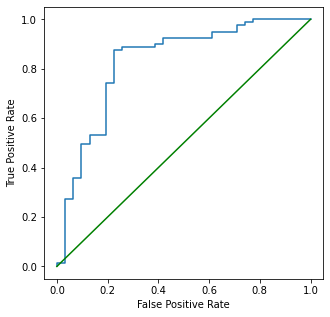

In [500]:
%%time

# run with base hyper parameters

model = LogisticRegression(random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print_model_results(y_test, y_pred)
display_roc(y_test, model.predict_proba(X_test)[:, -1])

In [501]:
%%time

# Find best hyperparameters
#   https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

hyper_best = None

if not hyper_best:
    param_grid = {
        # 'penalty': ['l2'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        # 'penalty': ['l1'],
        # 'solver': ['liblinear', 'saga'],
        'max_iter': [5, 10, 25, 50, 100, 250, 500],
        'C': [0.01, 0.1, 1.0, 10.0, 100.0],
    }
    hyper_search = GridSearchCV(model, param_grid, cv=5, verbose=1, n_jobs=4).fit(X_valid, y_valid)
    hyper_best = hyper_search.best_params_

print('Best hyperparameters =', hyper_best)

Fitting 5 folds for each of 175 candidates, totalling 875 fits
Best hyperparameters = {'C': 10.0, 'max_iter': 5, 'solver': 'sag'}
CPU times: total: 625 ms
Wall time: 6.83 s


Log loss = 6.476077688147909
[[23  8]
 [13 68]]
              precision    recall  f1-score   support

       False   0.638889  0.741935  0.686567        31
        True   0.894737  0.839506  0.866242        81

    accuracy                       0.812500       112
   macro avg   0.766813  0.790721  0.776405       112
weighted avg   0.823922  0.812500  0.816511       112

ROC AUC Score = 0.8546395858223815
CPU times: total: 125 ms
Wall time: 39 ms


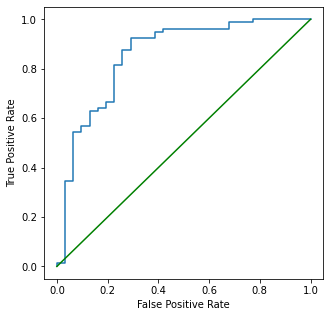

In [502]:
%%time

# Try retraining model with new hyperparameters

model = LogisticRegression(**hyper_best, random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print_model_results(y_test, y_pred)
display_roc(y_test, model.predict_proba(X_test)[:, -1])

## Stochastic Gradient Descent Classifier

In [503]:
%%time

# run with base hyper parameters

model = SGDClassifier(random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print_model_results(y_test, y_pred)
# display_roc(y_test, model.predict_proba(X_test)[:, -1])

Log loss = 8.634744073567058
[[24  7]
 [21 60]]
              precision    recall  f1-score   support

       False   0.533333  0.774194  0.631579        31
        True   0.895522  0.740741  0.810811        81

    accuracy                       0.750000       112
   macro avg   0.714428  0.757467  0.721195       112
weighted avg   0.795274  0.750000  0.761202       112

CPU times: total: 62.5 ms
Wall time: 19 ms


In [504]:
%%time

# Find best hyperparameters
#   https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
#   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

hyper_best = None

if not hyper_best:
    param_grid = {
        # 'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber'],
        'penalty': ['l2', 'l1', 'elasticnet'],
        'max_iter': [2, 4, 8, 16, 32, 64, 128],
        # 'learning_rate': ['constant', 'optimal', 'adaptive'],
        # 'eta0': [0.5, 1, 2, 4, 8, 16, 32],
    }
    hyper_search = GridSearchCV(model, param_grid, cv=5, verbose=1).fit(X_valid, y_valid)
    hyper_best = hyper_search.best_params_

print('Best hyperparameters =', hyper_best)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
Best hyperparameters = {'max_iter': 4, 'penalty': 'l2'}
CPU times: total: 1.23 s
Wall time: 870 ms


In [505]:
%%time

# Try retraining model with new hyperparameters

model = SGDClassifier(**hyper_best, random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print_model_results(y_test, y_pred)
# display_roc(y_test, model.predict_proba(X_test)[:, -1])

Log loss = 8.94319739829217
[[14 17]
 [12 69]]
              precision    recall  f1-score   support

       False   0.538462  0.451613  0.491228        31
        True   0.802326  0.851852  0.826347        81

    accuracy                       0.741071       112
   macro avg   0.670394  0.651732  0.658788       112
weighted avg   0.729292  0.741071  0.733591       112

CPU times: total: 78.1 ms
Wall time: 18.5 ms


## KNN

Log loss = 9.868264662693955
[[25  6]
 [26 55]]
              precision    recall  f1-score   support

       False   0.490196  0.806452  0.609756        31
        True   0.901639  0.679012  0.774648        81

    accuracy                       0.714286       112
   macro avg   0.695918  0.742732  0.692202       112
weighted avg   0.787758  0.714286  0.729008       112

ROC AUC Score = 0.7646356033452808
CPU times: total: 188 ms
Wall time: 42 ms


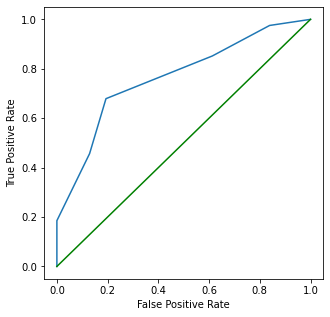

In [506]:
%%time

# run with base hyper parameters

model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print_model_results(y_test, y_pred)
display_roc(y_test, model.predict_proba(X_test)[:, -1])

In [507]:
%%time

# Find best hyperparameters
#   https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
#   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

hyper_best = None

if not hyper_best:
    param_grid = {
        'n_neighbors': [5, 10, 15, 20, 25],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [10, 20, 30, 40, 50],
    }
    hyper_search = GridSearchCV(model, param_grid, cv=5, verbose=1).fit(X_valid, y_valid)
    hyper_best = hyper_search.best_params_

print('Best hyperparameters =', hyper_best)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best hyperparameters = {'algorithm': 'kd_tree', 'leaf_size': 20, 'n_neighbors': 20}
CPU times: total: 13.1 s
Wall time: 5.08 s


Log loss = 13.56882643007465
[[28  3]
 [41 40]]
              precision    recall  f1-score   support

       False   0.405797  0.903226  0.560000        31
        True   0.930233  0.493827  0.645161        81

    accuracy                       0.607143       112
   macro avg   0.668015  0.698526  0.602581       112
weighted avg   0.785076  0.607143  0.621590       112

ROC AUC Score = 0.7536837913182
CPU times: total: 578 ms
Wall time: 133 ms


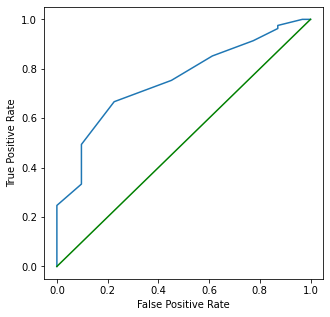

In [508]:
%%time

# Try retraining model with new hyperparameters

model = KNeighborsClassifier(**hyper_best)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print_model_results(y_test, y_pred)
display_roc(y_test, model.predict_proba(X_test)[:, -1])

## Decision Tree

Log loss = 10.793460433825592
[[18 13]
 [22 59]]
              precision    recall  f1-score   support

       False   0.450000  0.580645  0.507042        31
        True   0.819444  0.728395  0.771242        81

    accuracy                       0.687500       112
   macro avg   0.634722  0.654520  0.639142       112
weighted avg   0.717187  0.687500  0.698115       112

ROC AUC Score = 0.6545201115093588
CPU times: total: 62.5 ms
Wall time: 38.5 ms


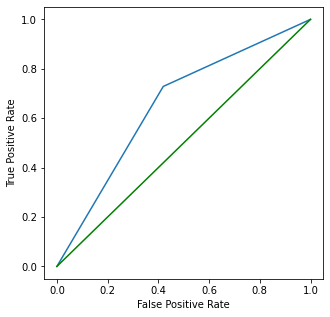

In [509]:
%%time

# run with base hyper parameters

model = DecisionTreeClassifier(random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print_model_results(y_test, y_pred)
display_roc(y_test, model.predict_proba(X_test)[:, -1])

In [510]:
%%time

# Find best hyperparameters
#   https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

hyper_best = None

if not hyper_best:
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [2, 4, 8, 16, 32],
        'max_leaf_nodes': [2, 4, 8, 16, 32],
        'max_features': [16, 32, 64, 128, 256],
        # 'max_features': ['auto', 'sqrt', 'log2'],
        # 'min_samples_leaf': [1, 2, 3, 4],
    }
    hyper_search = GridSearchCV(model, param_grid, cv=5, verbose=1, n_jobs=4).fit(X_valid, y_valid)
    hyper_best = hyper_search.best_params_

print('Best hyperparameters =', hyper_best)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best hyperparameters = {'criterion': 'entropy', 'max_depth': 16, 'max_features': 256, 'max_leaf_nodes': 16, 'splitter': 'random'}
CPU times: total: 734 ms
Wall time: 6.15 s


Log loss = 9.559911287647619
[[21 10]
 [21 60]]
              precision    recall  f1-score   support

       False   0.500000  0.677419  0.575342        31
        True   0.857143  0.740741  0.794702        81

    accuracy                       0.723214       112
   macro avg   0.678571  0.709080  0.685022       112
weighted avg   0.758291  0.723214  0.733986       112

ROC AUC Score = 0.717642373556352
CPU times: total: 31.2 ms
Wall time: 31 ms


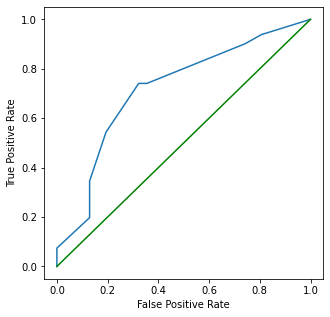

In [511]:
%%time

# Try retraining model with new hyperparameters

model = DecisionTreeClassifier(**hyper_best, random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print_model_results(y_test, y_pred)
display_roc(y_test, model.predict_proba(X_test)[:, -1])

## Random Forest

Log loss = 6.784516734347483
[[15 16]
 [ 6 75]]
              precision    recall  f1-score   support

       False   0.714286  0.483871  0.576923        31
        True   0.824176  0.925926  0.872093        81

    accuracy                       0.803571       112
   macro avg   0.769231  0.704898  0.724508       112
weighted avg   0.793760  0.803571  0.790394       112

ROC AUC Score = 0.8454798884906413
CPU times: total: 172 ms
Wall time: 176 ms


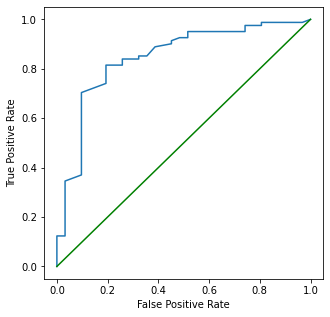

In [512]:
%%time

# run with base hyper parameters

model = RandomForestClassifier(random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print_model_results(y_test, y_pred)
display_roc(y_test, model.predict_proba(X_test)[:, -1])

In [513]:
%%time

# Find best hyperparameters
#   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

hyper_best = None
# hyper_best = {'max_features': 32, 'n_estimators': 100} # 83.04
# hyper_best = {'max_features': 24, 'n_estimators': 150} # 83.93
# hyper_best = {'max_features': 20, 'n_estimators': 150} # 84.82
# hyper_best = {'max_features': 20, 'n_estimators': 175} # 85.71

if not hyper_best:
    param_grid = {
        'n_estimators': [150, 200],
        # 'max_depth': [3, 5, 7, 9, 11],
        # 'max_features': [8, 16, 32, 64, 128],
        'max_features': [20, 32, 64, 128],
        # 'max_features': ['sqrt', 'log2', None],
        #
        # 'criterion': ['gini', 'entropy'],
        # 'class_weight': ['balanced', 'balanced_subsample'],
        # 'min_samples_split': [10, 15, 25, 50],
        # 'min_samples_leaf': [5, 10, 15],
        # 'oob_score': [False, True],
        # 'max_leaf_nodes': [2, 4, 8, 16, 32, 64]
    }
    hyper_search = GridSearchCV(model, param_grid, cv=5, verbose=1, n_jobs=4).fit(X_valid, y_valid)
    hyper_best = hyper_search.best_params_

print('Best hyperparameters =', hyper_best)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best hyperparameters = {'max_features': 20, 'n_estimators': 150}
CPU times: total: 297 ms
Wall time: 2.86 s


Log loss = 5.242564238283782
[[21 10]
 [ 7 74]]
              precision    recall  f1-score   support

       False   0.750000  0.677419  0.711864        31
        True   0.880952  0.913580  0.896970        81

    accuracy                       0.848214       112
   macro avg   0.815476  0.795500  0.804417       112
weighted avg   0.844707  0.848214  0.845735       112

ROC AUC Score = 0.8582238152130625
CPU times: total: 266 ms
Wall time: 240 ms


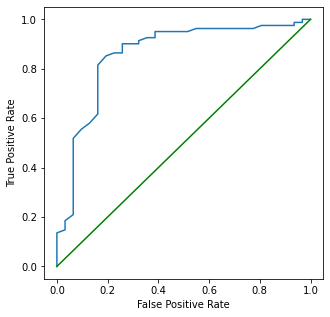

In [514]:
%%time

# Try retraining model with new hyperparameters

model = RandomForestClassifier(**hyper_best, random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print_model_results(y_test, y_pred)
display_roc(y_test, model.predict_proba(X_test)[:, -1])

## Gradient Boosting Classifier

Log loss = 6.476091966673449
[[21 10]
 [11 70]]
              precision    recall  f1-score   support

       False   0.656250  0.677419  0.666667        31
        True   0.875000  0.864198  0.869565        81

    accuracy                       0.812500       112
   macro avg   0.765625  0.770808  0.768116       112
weighted avg   0.814453  0.812500  0.813406       112

ROC AUC Score = 0.8327359617682198
CPU times: total: 234 ms
Wall time: 250 ms


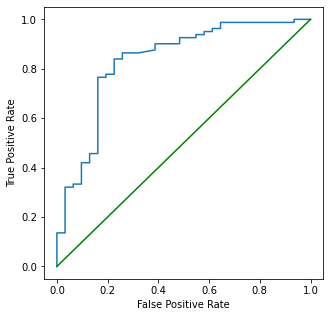

In [515]:
%%time

# run with base hyper parameters

model = GradientBoostingClassifier(random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print_model_results(y_test, y_pred)
display_roc(y_test, model.predict_proba(X_test)[:, -1])

In [516]:
%%time

# Find best hyperparameters
#   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
#   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

hyper_best = None
# hyper_best = {'learning_rate': 0.1, 'max_depth': 9, 'max_features': 256, 'n_estimators': 50} # 83.04

if not hyper_best:
    param_grid = {
        'learning_rate': [0.1, 1, 10],
        'n_estimators': [5, 50, 100, 250, 500],
        'max_depth': [5, 7, 9, 11, 13],
        'max_features': [64, 128, 256],
        # 'criterion': ['friedman_mse', 'squared_error', 'mse'],
        # 'max_features': ['auto', 'sqrt', 'log2'],
    }
    hyper_search = GridSearchCV(model, param_grid, cv=5, verbose=1, n_jobs=4).fit(X_valid, y_valid)
    hyper_best = hyper_search.best_params_

print('Best hyperparameters =', hyper_best)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
Best hyperparameters = {'learning_rate': 0.1, 'max_depth': 9, 'max_features': 256, 'n_estimators': 50}
CPU times: total: 1.34 s
Wall time: 42.5 s


Log loss = 5.859313823953076
[[23  8]
 [11 70]]
              precision    recall  f1-score   support

       False   0.676471  0.741935  0.707692        31
        True   0.897436  0.864198  0.880503        81

    accuracy                       0.830357       112
   macro avg   0.786953  0.803067  0.794098       112
weighted avg   0.836276  0.830357  0.832672       112

ROC AUC Score = 0.8440860215053763
CPU times: total: 281 ms
Wall time: 267 ms


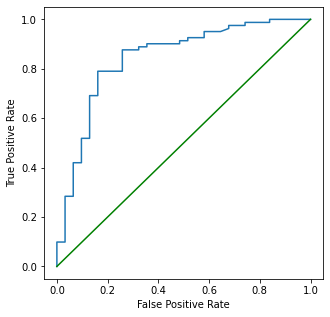

In [517]:
%%time

# Try retraining model with new hyperparameters

model = GradientBoostingClassifier(**hyper_best, random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print_model_results(y_test, y_pred)
display_roc(y_test, model.predict_proba(X_test)[:, -1])

## XGBoost Classifier

Log loss = 7.092855830868282
[[21 10]
 [13 68]]
              precision    recall  f1-score   support

       False   0.617647  0.677419  0.646154        31
        True   0.871795  0.839506  0.855346        81

    accuracy                       0.794643       112
   macro avg   0.744721  0.758463  0.750750       112
weighted avg   0.801450  0.794643  0.797445       112

ROC AUC Score = 0.8112305854241337
CPU times: total: 2.97 s
Wall time: 408 ms


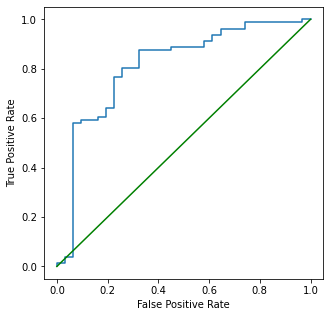

In [518]:
%%time

# run with base hyper parameters

model = xgb.XGBClassifier(random_state=SEED, eval_metric='mlogloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print_model_results(y_test, y_pred)
display_roc(y_test, model.predict_proba(X_test)[:, -1])

In [519]:
%%time

# Find best hyperparameters
#   https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
#   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

hyper_best = None

if not hyper_best:
    param_grid = {
        'learning_rate': [0.01, 0.1, 1, 10, 100],
        # 'n_estimators': [5, 50, 100, 250, 500],
        'max_depth': [1, 3, 5, 7, 9],
    }
    hyper_search = GridSearchCV(model, param_grid, cv=5, verbose=1).fit(X_valid, y_valid)
    hyper_best = hyper_search.best_params_

print('Best hyperparameters =', hyper_best)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best hyperparameters = {'learning_rate': 1, 'max_depth': 5}
CPU times: total: 3min 37s
Wall time: 33.1 s


Log loss = 9.251543634075741
[[19 12]
 [18 63]]
              precision    recall  f1-score   support

       False   0.513514  0.612903  0.558824        31
        True   0.840000  0.777778  0.807692        81

    accuracy                       0.732143       112
   macro avg   0.676757  0.695341  0.683258       112
weighted avg   0.749633  0.732143  0.738809       112

ROC AUC Score = 0.7853444842692154
CPU times: total: 2.36 s
Wall time: 400 ms


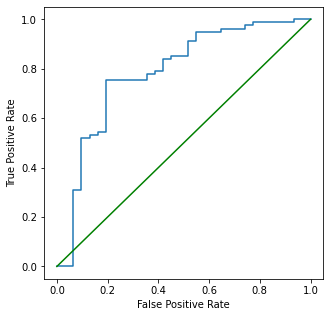

In [520]:
%%time

# Try retraining model with new hyperparameters

model = xgb.XGBClassifier(**hyper_best, random_state=SEED, eval_metric='mlogloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print_model_results(y_test, y_pred)
display_roc(y_test, model.predict_proba(X_test)[:, -1])

## Conclusion

Switching to a classifier model definitely helped, but I still couldn't quite get to a 90% accuracy.
My closest was ~84-85% with a Random Forest Classifier.
I think its a combination of not enough data points and just not very useful data.

I tend to give an anime a score of 7 more than anything else, heavily skewing my data.
I also tend to not be very critical, so entries with a score below 5 are very rare.